### Importación de librerías a utilizar

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Función de polling table: Tabla de sondeo para ONUs

In [2]:
def create_polling_table(onu_no, onu_olt_dist, grant_size,link_speed):
    c = 2*1e5
    # Inicialización de tabla con sondeos
    polling_table = np.zeros((onu_no,4))
    
    #indice de ONU
    polling_table[:, 0] = np.arange(1, onu_no + 1)

    # Round Time Trip (RTT)
    polling_table[:, 1] = 2 * onu_olt_dist / c

    # Tiempo de Transmisión
    polling_table[:, 2] = grant_size * 8 / link_speed

    # Columna 4: Tiempo total (RTT + tiempo de transmisión).
    polling_table[:, 3] = polling_table[:, 1] + polling_table[:, 2]

    return polling_table

### Función pkt_arr_times: Tiempos de llegada de paquetes

In [3]:
def pkt_arr_times(type, par1, par2=None, max_pkts=None):
    if type == 'deterministic':
        avg_arr_time = par1
        pkt_arr_time = avg_arr_time * np.ones(max_pkts)

    elif type == 'exponential':
        avg_arr_time = par1
        pkt_arr_time = np.random.exponential(avg_arr_time, max_pkts)

    elif type == 'uniform':
        min_arr_time = par1
        max_arr_time = par2
        pkt_arr_time = min_arr_time + (max_arr_time - min_arr_time) * np.random.rand(max_pkts)

    elif type == 'GP':  # Generalized Pareto distribution
        k = par1
        sigma = par2
        theta = 0  # minimum value for time is 0
        pkt_arr_time = np.random.default_rng().pareto(k, max_pkts) * sigma + theta

    elif type == 'gamma':
        a = par1
        b = par2
        pkt_arr_time = np.random.gamma(a, b, max_pkts)

    elif type == 'Gaussian':
        mean = par1
        variance = par2
        pkt_arr_time = mean + variance * np.abs(np.random.randn(max_pkts))

    else:
        raise ValueError("Unsupported distribution type")

    return pkt_arr_time


In [4]:
import numpy as np
from scipy.stats import expon

# Parámetros iniciales
Lambda = np.arange(0.1, 1.1, 0.1)
onu_no = 16  # Número total de ONUs
c = 2.04218 * 1e5  # Velocidad de la luz en fibra (2 x 10^5 km/s)
onu_buff = 10e3  # Tamaño del buffer de ONU (10 KBytes)
grant_reqst_size = 64  # Tamaño de mensaje de asignación o solicitud (64 bytes)
onu_max_grant = 11000  # Tamaño máximo de asignación de ONU (bytes)
onu_olt_dist = 20 * np.ones(onu_no)  # Distancia OLT-ONU (km)

avg_pkt_delay_all = np.zeros(len(Lambda))  # Retraso promedio de paquetes
avg_pkt_trx_delay_all = np.zeros(len(Lambda))  # Retraso promedio de transmisión de paquetes
polling_cycles = np.zeros(len(Lambda))  # Ciclos de sondeo

R_p = 2488e6  # Tasa total de datos de enlace ascendente (en bps) = 2488 Mbps
R_pb = R_p / 8  # Tasa total de datos de enlace ascendente (en Bps)
R_o = 1244e6  # Máxima tasa de datos de enlace ascendente de ONU (en bps) = 1244 Mbps
R_ob = R_o / 8  # Máxima tasa de datos de enlace ascendente de ONU (en Bps)

pkt_sz_min = 64  # Tamaño mínimo de paquete Ethernet
pkt_sz_max = 4542  # Tamaño máximo de paquete Ethernet
pkt_sz_avg = (pkt_sz_min + pkt_sz_max) / 2  # Tamaño promedio de paquete Ethernet
max_pkts = 1e3  # Número máximo de paquetes por ONU
T_guard = 5e-6  # Tiempo de guarda (5 µs)

for k in range(len(Lambda)):  # Iterar sobre los valores de carga
    lambda_ = Lambda[k]  # Carga actual
    onu_load = lambda_  # Carga por ONU
    R_eff = onu_load * R_ob  # Tasa de datos por ONU (en Bps)
    avg_pkt_rate = R_eff / pkt_sz_avg  # Tasa promedio de llegada de paquetes (promedio de longitud de paquete = 803 Bytes)

    # Inicialización de matrices
    onu_pkt_arr_times = np.zeros((onu_no, int(max_pkts)))  # Tiempos entre llegadas de paquetes en ONUs
    onu_pkt_sizes = np.zeros((onu_no, int(max_pkts)))  # Tamaños de paquetes en las ONUs
    onu_pkt_tx_times = np.zeros((onu_no, int(max_pkts)))  # Tiempos de transmisión de paquetes desde las ONUs
    olt_pkt_rx_times = np.zeros((onu_no, int(max_pkts)))  # Tiempos de recepción de paquetes en el OLT
    onu_pkt_drop_count = np.zeros(onu_no)  # Conteo de paquetes descartados por cada ONU
    olt_grant_tx_times = np.zeros(onu_no)  # Tiempos para enviar asignaciones desde los OLTs
    onu_grant_arr_times = np.zeros(onu_no)  # Tiempos en los que las ONUs reciben mensajes de asignación

    # onu_grant_req inicializado a cero
    onu_grant_req = np.zeros(onu_no)  # Inicializar todas las ONUs con cero asignaciones

    # Crear la tabla de sondeo (polling table) - debes implementar esta función
    polling_table = create_polling_table(onu_no, onu_olt_dist, onu_grant_req, R_p)  # Debes implementar esta función

    # Calcular los tiempos de llegada y tamaños de paquetes en todas las ONUs
    for o in range(onu_no):
        # Generar tiempos de llegada de paquetes
        pkt_arr_time = expon(scale=1 / avg_pkt_rate).rvs(size=int(max_pkts))  # Tiempos entre llegadas con distribución exponencial
        onu_pkt_arr_times[o, :] = np.cumsum(pkt_arr_time)  # Sumar cumulativamente los tiempos de inter-arrival
        # Generar tamaños de paquetes aleatorios entre [64, 1542] Bytes
        onu_pkt_sizes[o, :] = np.random.randint(pkt_sz_min, pkt_sz_max + 1, size=int(max_pkts))
        # Calcular la tasa de paquetes generada para verificar con R_o
        rate = np.sum(onu_pkt_sizes[o, :]) / np.sum(pkt_arr_time)  # Solo para verificación con R_o

    # Inicialización del tiempo de simulación
    current_time = 0  # Tiempo actual de la simulación
    packets_processed = 0  # Número de paquetes procesados
    polling_cycle_no = 0  # Contador de ciclos de sondeo

    # Inicio de la simulación de paquetes
    while packets_processed < onu_no * max_pkts:  # Crear ciclos de sondeo hasta que todos los paquetes sean procesados
        onu_schd_indx = np.argsort(polling_table[:, 3])  # Ordenar ONUs por latencia total

        # Calcular los tiempos de programación de asignación en OLT y los tiempos de llegada a las ONUs
        olt_time_cursor = current_time
        onus_granted = 0

        for o in range(len(onu_schd_indx)):
            ok = onu_schd_indx[o]  # ONU actual
            if onus_granted == 0:
                olt_grant_tx_times[ok] = olt_time_cursor
                onu_grant_arr_times[ok] = olt_grant_tx_times[ok] + onu_olt_dist[ok] / c
                onus_granted += 1
            else:
                bk = onu_schd_indx[o - 1]  # ONU previa
                olt_grant_tx_times[ok] = (
                    olt_grant_tx_times[bk]
                    + polling_table[bk, 3]
                    + (grant_reqst_size / R_pb)
                    + T_guard
                    - polling_table[ok, 1]
                )
                olt_time_cursor = olt_grant_tx_times[ok]
                onu_grant_arr_times[ok] = olt_grant_tx_times[ok] + onu_olt_dist[ok] / c
                onus_granted += 1

        # Enviar mensajes de asignación a las ONUs en orden temporal
        for o in range(len(onu_schd_indx)):
            ok = onu_schd_indx[o]
            onu_time_cursor = onu_grant_arr_times[ok]  # Avanzar el cursor temporal
            buff_pkt_idx = np.where(onu_pkt_tx_times[ok, :] == 0)[0]  # Índices de paquetes en buffer

            buff_usage = 0  # Uso del buffer
            pending_buff = 0  # Paquetes pendientes

            for j in range(len(buff_pkt_idx)):
                jk = buff_pkt_idx[j]

                # Si el paquete no ha llegado antes del tiempo de asignación, romper el bucle
                if onu_pkt_arr_times[ok, jk] > onu_grant_arr_times[ok]:
                    onu_grant_req[ok] = min(pending_buff + grant_reqst_size, onu_max_grant)  # Actualizar solicitud para el siguiente ciclo
                    break
                else:
                    buff_usage += onu_pkt_sizes[ok, jk]

                # Si el paquete excede el tamaño de asignación actual, dejar pendiente
                if buff_usage > onu_grant_req[ok]:
                    pending_buff += onu_pkt_sizes[ok, jk]
                    if j == len(buff_pkt_idx) - 1:
                        onu_grant_req[ok] = min(pending_buff + grant_reqst_size, onu_max_grant)  # Actualizar solicitud para el siguiente ciclo
                        break
                    else:
                        continue

            # Procesar paquetes
            packets_processed += 1

            if buff_usage > onu_buff:  # Si el buffer de la ONU se desborda, el paquete se descarta
                onu_pkt_tx_times[ok, jk] = np.nan
                olt_pkt_rx_times[ok, jk] = np.nan
                onu_pkt_drop_count[ok] += 1

            # Todas las verificaciones pasaron: ahora transmitir el paquete
            onu_time_cursor += onu_pkt_sizes[ok, jk] / R_pb
            onu_pkt_tx_times[ok, jk] = onu_time_cursor
            olt_pkt_rx_times[ok, jk] = onu_pkt_tx_times[ok, jk] + onu_olt_dist[ok] / c

            # Fin de la transmisión de paquetes existentes en el buffer
            # Actualización del tiempo actual al final del ciclo
            current_time = (
                olt_grant_tx_times[ok] 
                + polling_table[ok, 3] 
                + (grant_reqst_size / R_pb) 
                + T_guard
            )

            # Actualización de la tabla de sondeo
            polling_table[:, 2] = onu_grant_req / R_p
            polling_table[:, 3] = polling_table[:, 1] + polling_table[:, 2]
            polling_cycle_no += 1  # Incrementar el contador de ciclos de sondeo

    # Resultado
    avg_pkt_delay_all[k] = np.mean(polling_table[:, 2])  # Promedio de retardo de paquete
    avg_pkt_trx_delay_all[k] = np.mean(polling_table[:, 3])  # Promedio de retardo total
    polling_cycles[k] = polling_cycle_no  # Número total de ciclos de sondeo

### Función plot_results: Gráfica de resultados según ciclo de trabajo 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(Lambda, polling_cycles, avg_pkt_delay_all, avg_pkt_trx_delay_all):
    # ============================ figure 1 ============================
    plt.figure()
    plt.plot(Lambda, polling_cycles, '-o', linewidth=2, color='b')
    plt.grid(True)
    plt.box(True)
    plt.xlim([0, 1])
    plt.ylim([0, np.max(polling_cycles) * 1.1])  # Ajusta el límite superior
    plt.xlabel('Effective network load $(\\rho)$', fontweight='bold', fontsize=12)
    plt.ylabel('Number of polling cycles', fontweight='bold', fontsize=12)
    plt.legend(['Limited service'], loc='upper right', fontsize=10)
    plt.title('Polling Cycles vs Effective Load')
    plt.show()

    # ============================ figure 2 ============================
    plt.figure()
    plt.semilogy(Lambda, avg_pkt_delay_all, '-o', linewidth=2, color='r')
    plt.grid(True)
    plt.box(True)
    plt.xlim([0, 1])
    plt.ylim([1e-4, 1e-1])  # Ajusta el rango logarítmico
    plt.xlabel('Effective network load $(\\rho)$', fontweight='bold', fontsize=12)
    plt.ylabel('Average packet latency at ONU (sec)', fontweight='bold', fontsize=12)
    plt.legend(['Limited service'], loc='upper right', fontsize=10)
    plt.title('Average Packet Latency vs Effective Load')
    plt.show()

    # ============================ figure 3 ============================
    plt.figure()
    plt.semilogy(Lambda, avg_pkt_trx_delay_all, '-o', linewidth=2, color='g')
    plt.grid(True)
    plt.box(True)
    plt.xlim([0, 1])
    plt.ylim([1e-4, 1e-1])  # Ajusta el rango logarítmico
    plt.xlabel('Effective network load $(\\rho)$', fontweight='bold', fontsize=12)
    plt.ylabel('Average end-to-end packet latency (sec)', fontweight='bold', fontsize=12)
    plt.legend(['Limited service'], loc='upper right', fontsize=10)
    plt.title('End-to-End Packet Latency vs Effective Load')
    plt.show()


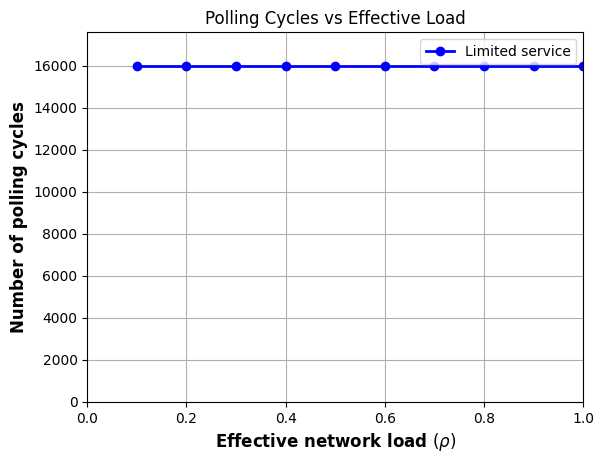

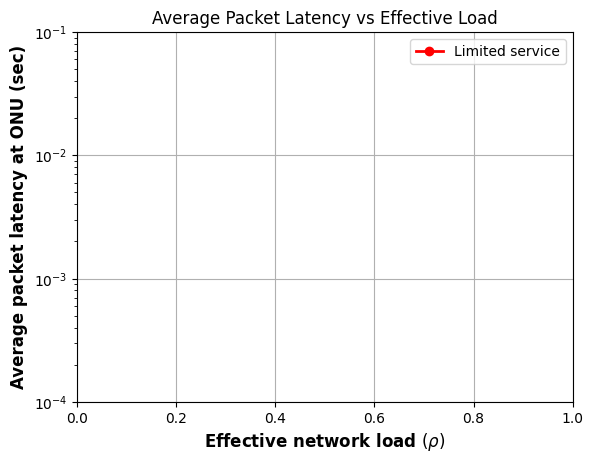

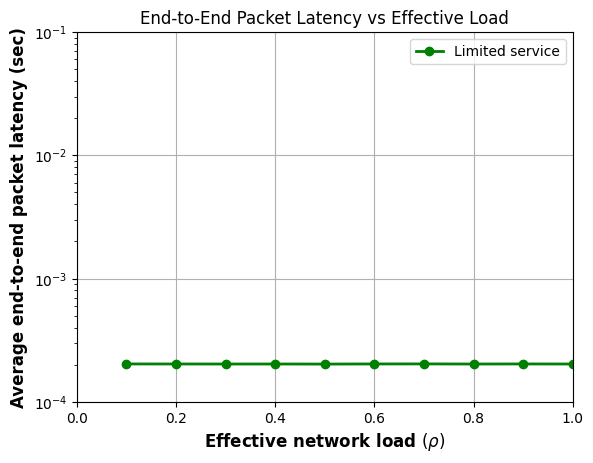

In [6]:
plot_results(Lambda, polling_cycles, avg_pkt_delay_all, avg_pkt_trx_delay_all)